In [1]:
from __future__ import print_function, division
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Distortion check with chessboard

There are two types of distortions

* Radial Distortion (most common)
  * distorts the edges of images
  * makes lines or objects appear more or less curved
  * measured in $(k1, k2, k3)$
  * ![radial distortion](assets/radial_distortion.png)
* Tangential Distortion
  * when a camera's lens is not perfectly aligned
  * it makes the image look tilted
  * measured in $(p1, p2)$
  * ![image.png](assets/tangential_distortion.png)

## 1. ChessBoard Corners

* First step to deal with the image distortion is to calibrate a camera using the chessboard corners
* What are corners?
    * Corners are points where two black squares and two white squares interesect
    * In OpenCV,
        * `cv2.findChessboardCorners(image, (nx, ny), None) -> ret, corners`
        * `cv2.drawChessboardCorners(image, (nx, ny), corners, ret) -> image`

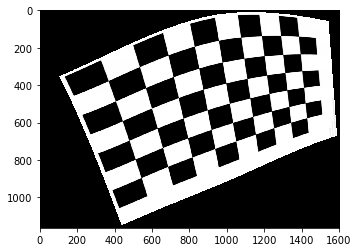

In [2]:
image = cv2.imread("assets/chessboard_distorted.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

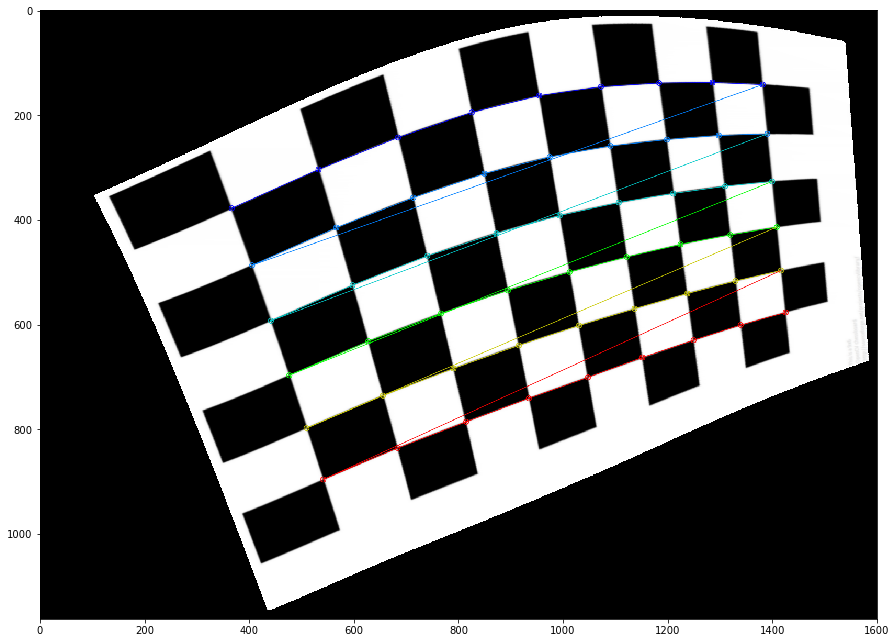

In [3]:
# 0. count nx, ny = (9, 6)
# 1. grayscale
# 2. find corners
# 3. draw corners
image = cv2.imread("assets/chessboard_distorted.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

nx = 9
ny = 6

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

if ret:
    result = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
    plt.figure(figsize=(15, 15));
    plt.imshow(image);

## 2. Calibrate Camera

This step is basically
* Run the above step multiple times and collect corners location
* Calibrate the camera
    * In OpenCV,
        * `ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pt_list, img_pt_list, img_size, None, None)`
            * `obj_pt_list` are true coordinates, (x, y, z) for corners
                * i.e `[(0, 0, 0), (1, 0, 0), (2, 0, 0), ... (8, 5, 0)]`
            * `img_pt_list` are actual coordinates, (x, y, z) for corners found in the actual images
                * i.e they are dirty numbers that need to be calibrated

In [4]:
import glob

In [5]:
# define object points: (x, y, z) coordinates for each corners
# there are 6 rows and 5 columns and z is 0 because it's 2-d
# e.g. (0, 0, 0), (1, 0, 0), (2, 0, 0), ..., (7, 5, 0)
obj_p = np.zeros([6 * 8, 3], np.float32)
obj_p[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)
obj_p

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 3.,  0.,  0.],
       [ 4.,  0.,  0.],
       [ 5.,  0.,  0.],
       [ 6.,  0.,  0.],
       [ 7.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  1.,  0.],
       [ 3.,  1.,  0.],
       [ 4.,  1.,  0.],
       [ 5.,  1.,  0.],
       [ 6.,  1.,  0.],
       [ 7.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  2.,  0.],
       [ 2.,  2.,  0.],
       [ 3.,  2.,  0.],
       [ 4.,  2.,  0.],
       [ 5.,  2.,  0.],
       [ 6.,  2.,  0.],
       [ 7.,  2.,  0.],
       [ 0.,  3.,  0.],
       [ 1.,  3.,  0.],
       [ 2.,  3.,  0.],
       [ 3.,  3.,  0.],
       [ 4.,  3.,  0.],
       [ 5.,  3.,  0.],
       [ 6.,  3.,  0.],
       [ 7.,  3.,  0.],
       [ 0.,  4.,  0.],
       [ 1.,  4.,  0.],
       [ 2.,  4.,  0.],
       [ 3.,  4.,  0.],
       [ 4.,  4.,  0.],
       [ 5.,  4.,  0.],
       [ 6.,  4.,  0.],
       [ 7.,  4.,  0.],
       [ 0.,  5.,  0.],
       [ 1.,  5.

In [6]:
obj_pt_list = []
img_pt_list = []

images = glob.glob("assets/calibration_wide/GO*.jpg")

for idx, fname in enumerate(images):
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)
    
    if ret:
        obj_pt_list.append(obj_p)
        img_pt_list.append(corners)


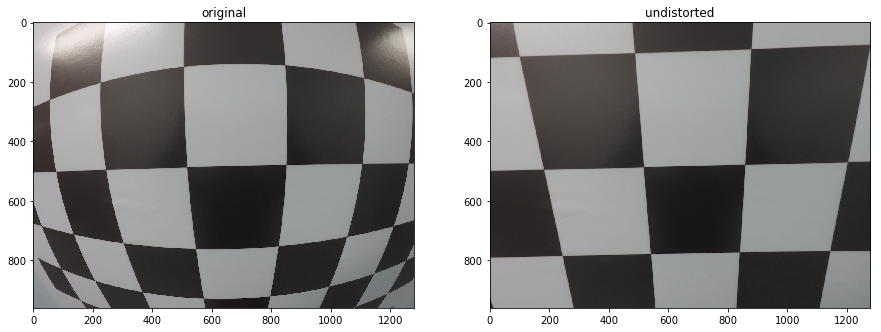

In [7]:
test_img = cv2.imread("assets/calibration_wide/test_image.jpg")
img_size = (test_img.shape[1], test_img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pt_list,
                                                   img_pt_list,
                                                   img_size, None, None)

dst = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite('assets/calibration_wide/test_undist.jpg', dst)


plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1);
plt.imshow(test_img);
plt.title("original");

plt.subplot(1, 2, 2);
plt.imshow(dst);
plt.title("undistorted");

## 3. Transform Perspective

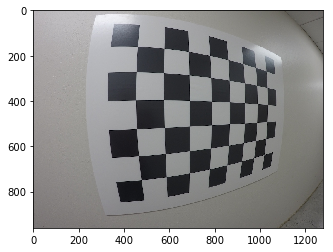

In [8]:
# we will transform this image to the bird's eye view
image = cv2.imread("assets/calibration_wide/GOPR0032.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

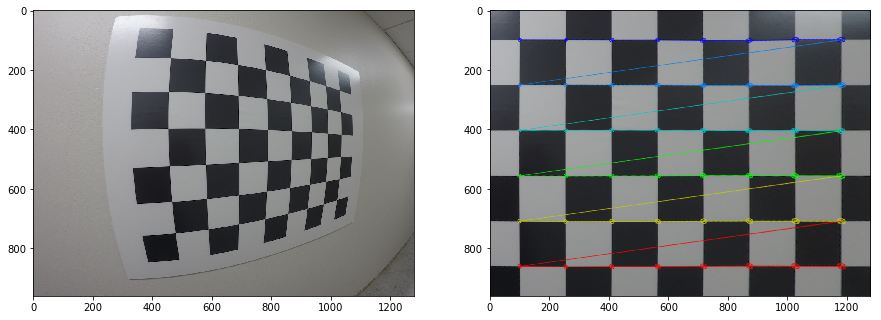

In [9]:
image = cv2.imread("assets/calibration_wide/GOPR0032.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

nx, ny = 8, 6

def undistort_warp(image, mtx, dist, nx, ny):
    """ Undistort and transform to the bird eye view
    
    Parameters
    ----------
    image : 3d-array (H, W, C)
    
    mtx : 2d-array (3, 3)
        Calibrate Camera Matrix
        
    dist: 2d-array (1, 5)
        Calibrate camera coefficient matrix
        [k1, k2, p1, p2, k3]
    
    """
    undist = cv2.undistort(image, mtx, dist)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret:
        _ = cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)

        src = np.array([corners[0], corners[nx - 1], corners[-1], corners[-nx]], dtype=np.float32)

        offset = 100
        height, width = gray.shape

        dst = [[offset, offset],
               [width - offset, offset],
               [width - offset, height - offset],
               [offset, height - offset]]
        dst = np.array(dst, dtype=np.float32)

        M = cv2.getPerspectiveTransform(src, dst)    
        warped = cv2.warpPerspective(undist, M, (width, height))
    
    return warped, M

warped, M = undistort_warp(image, mtx, dist, nx, ny)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1);
plt.imshow(image);

plt.subplot(1, 2, 2);
plt.imshow(warped);

## 4. Apply sobel

In [10]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)    
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.abs(sobel)
    eight_bits_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    
    binary_output = np.zeros_like(eight_bits_sobel)
    binary_output[(thresh_min <= eight_bits_sobel) & (eight_bits_sobel <= thresh_max)] = 1
    
    return binary_output

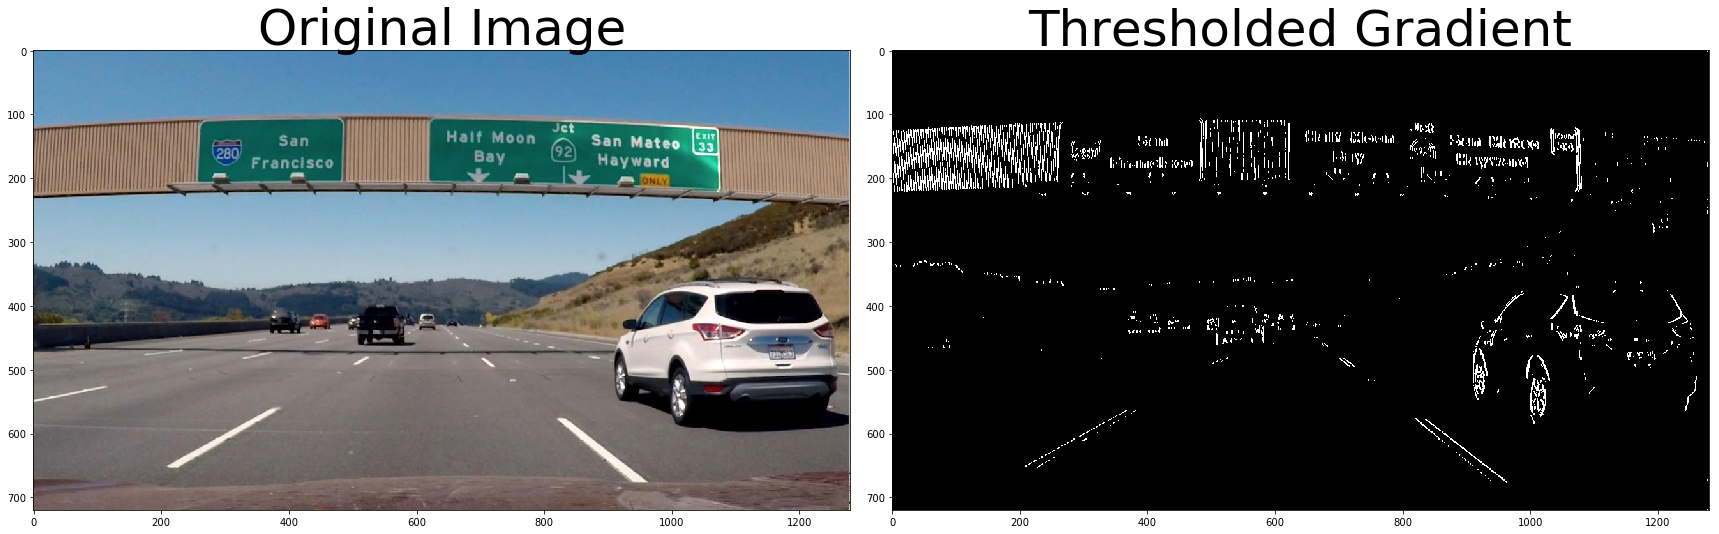

In [11]:
image = cv2.imread("assets/signs_vehicles_xygrad.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=50, thresh_max=255)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout();

ax1.imshow(image);
ax1.set_title('Original Image', fontsize=50);

ax2.imshow(grad_binary, cmap='gray');
ax2.set_title('Thresholded Gradient', fontsize=50);
